In [1]:
# import os
# os.getcwd()
# os.chdir('/home/chtung/project_MC')

import numpy as np
import time
from tqdm import tqdm, trange
from WLM import WLChain
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat

<Figure size 1152x1152 with 0 Axes>

In [2]:
def eval_sq_SHE(kappa, epsilon, chain, qq, rr, lm=[(0,0),(2,0),(4,0)], n_sample = 20, n_merge = 4, rayleigh=False, calculate_g_r=False, real=True):
    ## generate spectra of three different grids
    S_q_lm_list = []
    g_r_lm_list = []
    for i, grid in enumerate(['SC','RB','RT']):
        print(grid)
        S_q_lm_i = np.zeros([len(qq),len(lm)])
        g_r_lm_i = np.zeros([len(rr),len(lm)])
        for j in trange(n_sample):
            # chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
            chain.grid = grid
            chain.apply_SA = 0
            chain.d_exc = 0.1
            chain.f = 0.0
            chain.kappa = kappa
            chain.epsilon = epsilon

            chain.chain_grid()
            N = chain.N
            chain_box = chain.box
            
            chain.scatter_direct_SHE(qq, rr, lm, n_merge=n_merge, calculate_g_r=calculate_g_r, real=real)
            S_q_lm_i = S_q_lm_i + chain.S_q_lm
            g_r_lm_i = g_r_lm_i + chain.g_r_lm
        S_q_lm_list.append(S_q_lm_i/n_sample) # Append the S(Q) of given grid type
        g_r_lm_list.append(g_r_lm_i/n_sample) # Append the g(r) of given grid type

    ## Rayleigh chain
    if rayleigh:
        grid = 'KP'
        print(grid)
        S_q_lm_i = np.zeros([len(qq),len(lm)])
        g_r_lm_i = np.zeros([len(rr),len(lm)])
        chain.a = kappa
        for j in trange(n_sample):
            chain.chain()
            chain.scatter_direct_SHE(qq, rr, lm, n_merge=n_merge, calculate_g_r=calculate_g_r, real=real)
            S_q_lm_i = S_q_lm_i + chain.S_q_lm 
            g_r_lm_i = g_r_lm_i + chain.g_r_lm 
        S_q_lm_list.append(S_q_lm_i/n_sample) # Append the S(Q) of given grid type
        g_r_lm_list.append(g_r_lm_i/n_sample) # Append the g(r) of given grid type

    if calculate_g_r:
        return np.array(S_q_lm_list), np.array(g_r_lm_list)
    else:
        return np.array(S_q_lm_list)

In [3]:
## Chain parameters
# Coordinate of C atoms in each unit
# unit_C = load('b_c.dat')';
unit_C = np.zeros((3,1))

# Degree of polymerization
N_backbone = 1000

# Chain stiffness (placeholder)
a_backbone = 1

# Unit persistence
lambda_backbone = 1

# Call WLChain class
chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
chain.apply_SA = 1
chain.d_exc = 0.1
chain.f = 0.0

kappa_list = np.array([10])
epsilon_list = [0]

n_q = 25
n_r = 51
qq = (np.logspace(-1,3,n_q))/N_backbone
rr = (np.arange(n_r))*2

lm=[(0,0),(2,0),(4,0)]

parameters_list = []
S_q_lm_list_param = []
g_r_lm_list_param = []
for kappa in kappa_list:
    for epsilon in epsilon_list:
        parameters_list.append([kappa, epsilon])
        
        # Chain stiffness
        chain.kappa = kappa
        chain.epsilon = epsilon

        S_q_lm_list, g_r_lm_list= eval_sq_SHE(kappa, epsilon, chain, qq, rr, lm,
                                 n_sample = 10, n_merge = 1, rayleigh=True, calculate_g_r=True, real=True)
        S_q_lm_list_param.append(S_q_lm_list)
        g_r_lm_list_param.append(g_r_lm_list)
        
        S_q_lm_list_param = np.array(S_q_lm_list_param)
        g_r_lm_list_param = np.array(g_r_lm_list_param)
        mdic = {"S_q_lm_list_param":S_q_lm_list_param, "g_r_lm_list_param":g_r_lm_list_param, "qq":qq, "rr":rr, "parameters_list":parameters_list}
        savemat("sq_lm_test_{},{}.mat".format(kappa,epsilon),mdic)

SC


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


RB


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


RT


100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


KP


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


/SNS/users/ccu/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/SNS/users/ccu/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


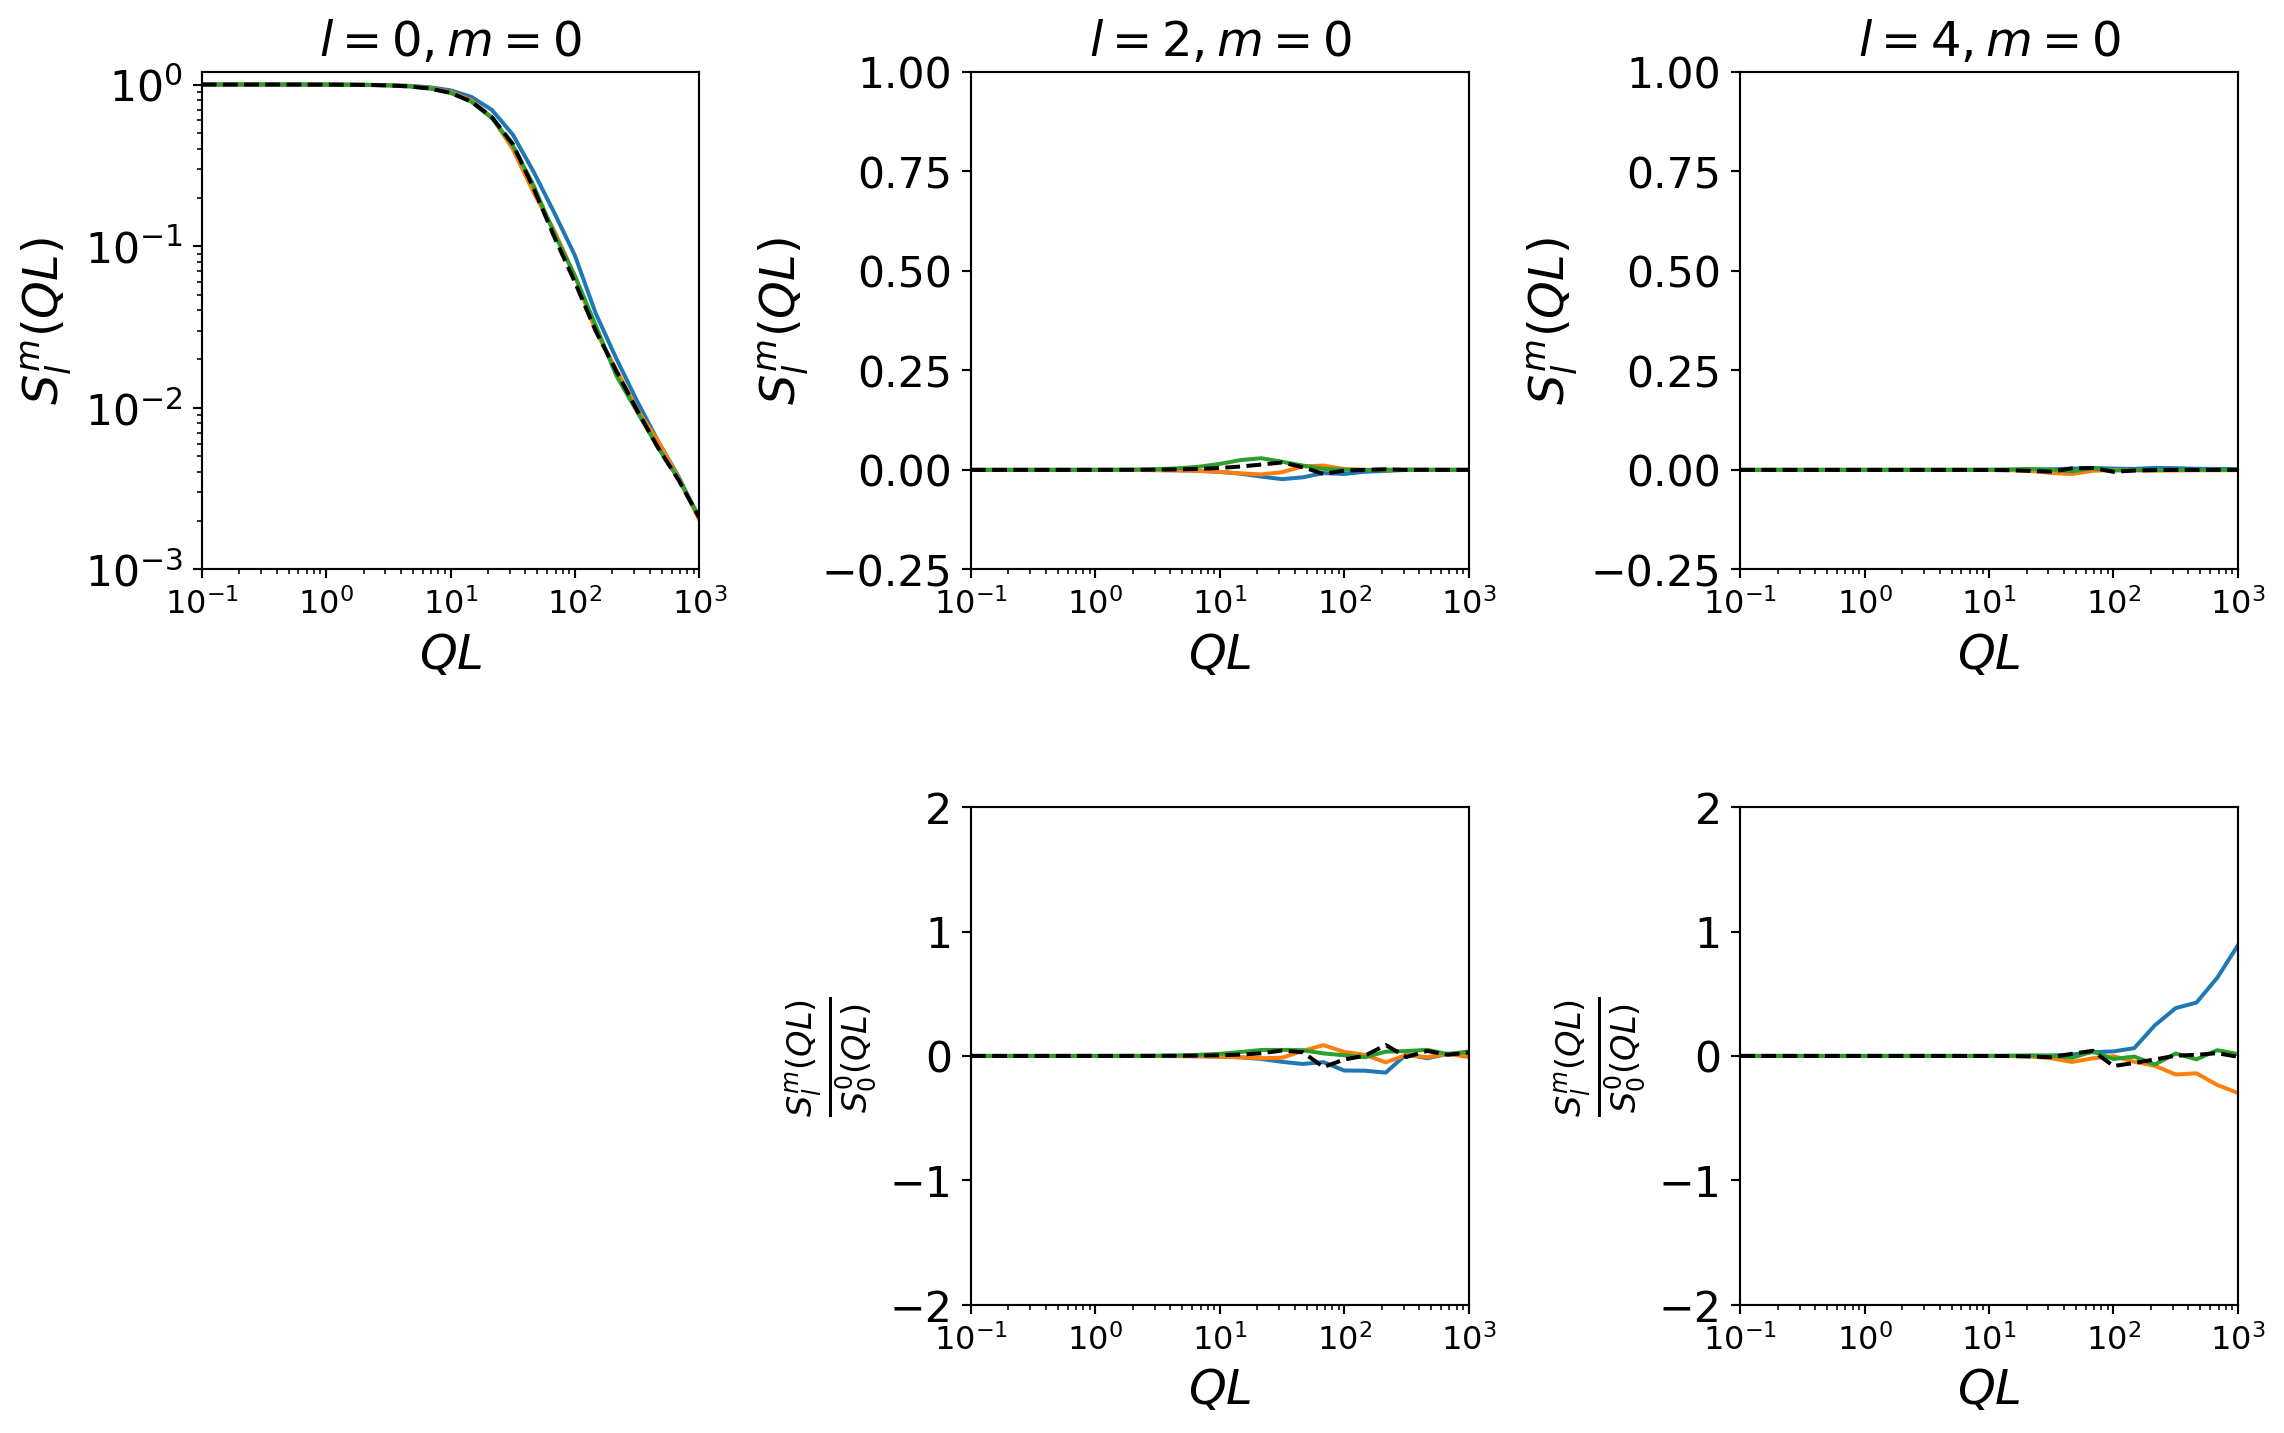

In [4]:
fig = plt.figure(figsize=(12, 8),dpi=192)
colors  = ['C0','C1','C2','C3','C4']

for i, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    for k, lm in enumerate([(0,0),(2,0),(4,0)]):
        ax = fig.add_subplot(2,3,k+1)
        for j, grid in enumerate(['SC','RD','RT']):
            S_q_lm_list = S_q_lm_list_param[i][j,:]
            S_q_lm = S_q_lm_list[:,k]
            
            ax.plot(qq*N_backbone,S_q_lm*np.sqrt(4*np.pi))
                
        j=3
        S_q_lm_list = S_q_lm_list_param[i][j,:]
        S_q_lm = S_q_lm_list[:,k]
        
        ax.plot(qq*N_backbone,S_q_lm*np.sqrt(4*np.pi),'--k')
        ax.set_title(r'$l={}, m={}$'.format(*lm),fontsize=18)
        ax.set_xlabel(r'$QL$',fontsize=18)
        ax.set_ylabel(r'$S_{l}^{m}(QL)$',fontsize=18)
        ax.set_xscale('log')
        ax.set_xlim([1e-1,1e3])
        
        ax.tick_params(axis='y', which='major', labelsize=16)
        ax.tick_params(axis='x', which='major', labelsize=12)
        ax.set_ylim([-0.25,1])
        if lm[0] == 0:
            ax.set_yscale('log')
            ax.set_ylim([1e-3,1.2])
            ax.set_xlim([1e-1,1e3])
        ax.set_box_aspect(1)

for i, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    for k, lm in enumerate([(2,0),(4,0)]):
        ax = fig.add_subplot(2,3,k+5)
        for j, grid in enumerate(['SC','RD','RT']):
            S_q_lm_list = S_q_lm_list_param[i][j,:]
            S_q_00 = S_q_lm_list[:,0]
            S_q_lm = S_q_lm_list[:,k+1]
            
            ax.plot(qq*N_backbone,S_q_lm/S_q_00, color=colors[j])
                
        j=3
        S_q_lm_list = S_q_lm_list_param[i][j,:]
        S_q_lm = S_q_lm_list[:,k+1]
        S_q_00 = S_q_lm_list[:,0]
        
        ax.plot(qq*N_backbone,S_q_lm/S_q_00,'--k')
        # ax.set_title(r'$l={}, m={}$'.format(*lm),fontsize=18)
        ax.set_xlabel(r'$QL$',fontsize=18)
        ax.set_ylabel(r'$\frac{S_{l}^m(QL)}{S_{0}^0(QL)}$',fontsize=18)
        ax.set_xscale('log')
        ax.set_xlim([1e-1,1e3])
        ax.set_ylim([-2,2])
        
        ax.tick_params(axis='y', which='major', labelsize=16)
        ax.tick_params(axis='x', which='major', labelsize=12)
        ax.set_box_aspect(1)
            
plt.tight_layout()


/tmp/ipykernel_2752131/1557745590.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([-3,1])


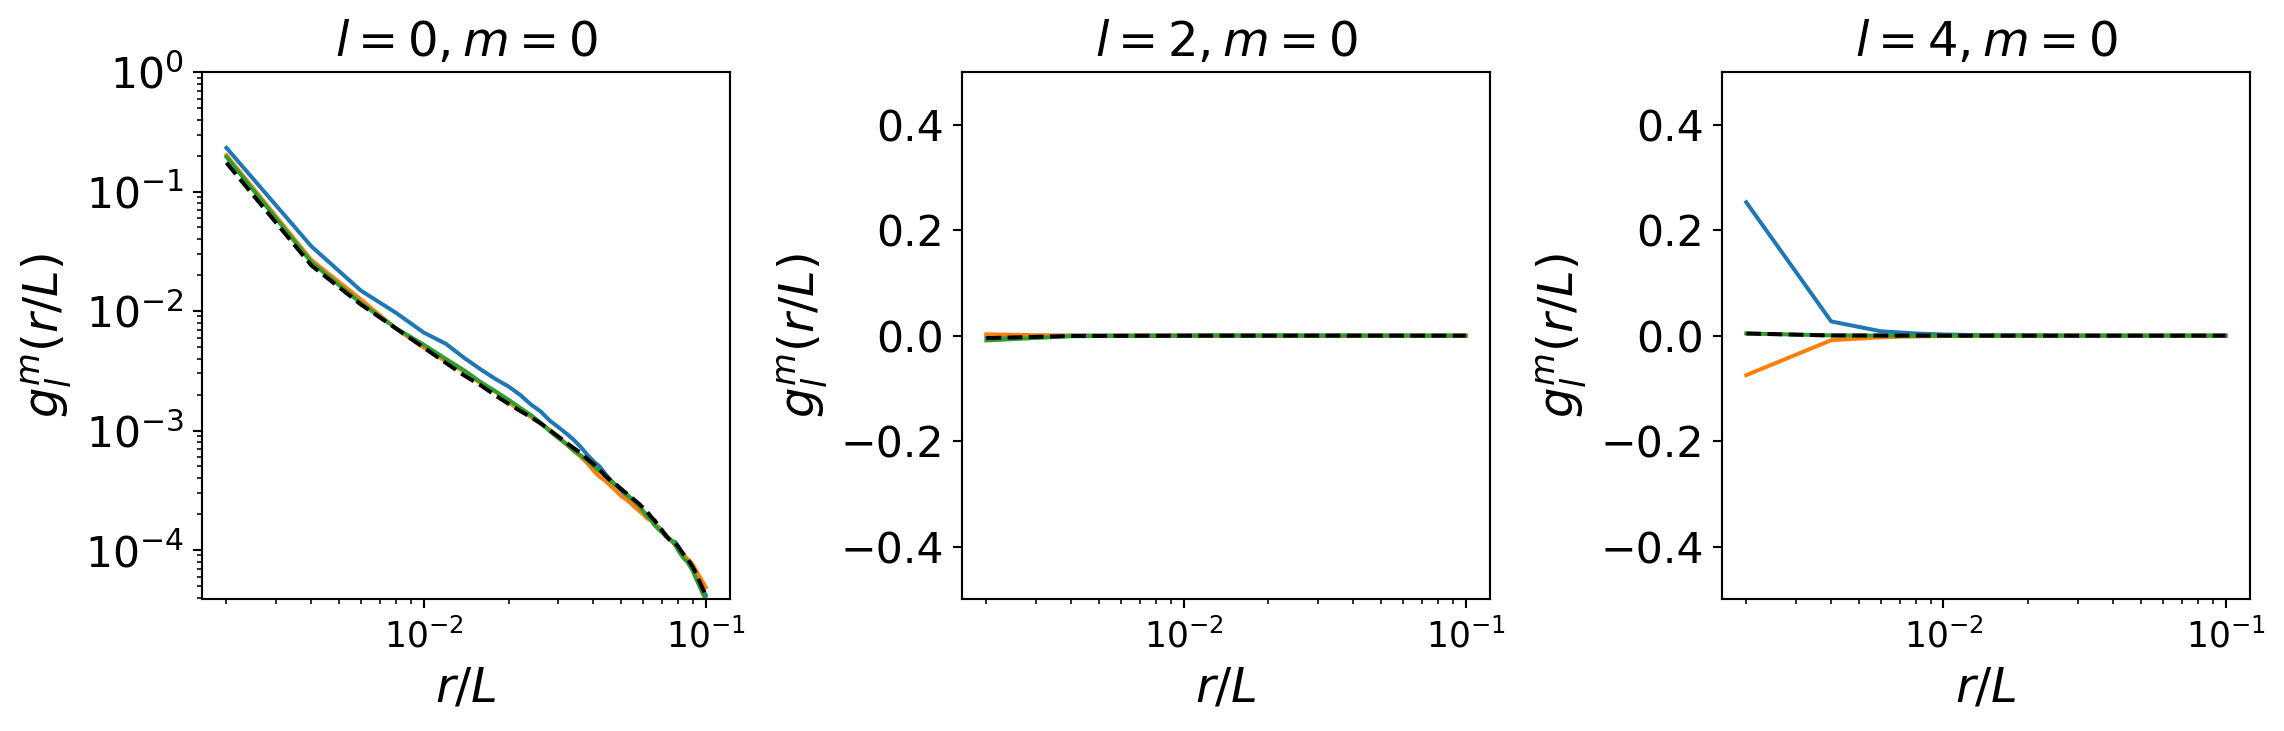

In [5]:
fig = plt.figure(figsize=(12, 8),dpi=192)
colors  = ['C0','C1','C2','C3','C4']

for i, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    for k, lm in enumerate([(0,0),(2,0),(4,0)]):
        ax = fig.add_subplot(2,3,k+1)
        for j, grid in enumerate(['SC','RD','RT']):
            g_r_lm_list = g_r_lm_list_param[i][j,:]
            g_r_lm = g_r_lm_list[:,k]
            
            ax.plot(rr[1:]/N_backbone,g_r_lm[1:]*np.sqrt(4*np.pi))
                
        j=3
        g_r_lm_list = g_r_lm_list_param[i][j,:]
        g_r_lm = g_r_lm_list[:,k]
        
        ax.plot(rr[1:]/N_backbone,g_r_lm[1:]*np.sqrt(4*np.pi), '--k')
        ax.set_title(r'$l={}, m={}$'.format(*lm),fontsize=18)
        ax.set_xlabel(r'$r/L$',fontsize=18)
        ax.set_ylabel(r'$g_{l}^{m}(r/L)$',fontsize=18)
        ax.set_xscale('log')
        ax.set_ylim([-0.5,0.5])
        
        if k==0:
            ax.set_yscale('log')
            ax.set_ylim([-3,1])
        
        ax.tick_params(axis='y', which='major', labelsize=16)
        ax.tick_params(axis='x', which='major', labelsize=13)
        ax.set_box_aspect(1)
            
plt.tight_layout()


In [6]:
from scipy.special import spherical_jn, lpmv, sph_harm
from math import factorial, sqrt, pi

def rsh(l, m, x, y, z):
    """
    Evaluate the real spherical harmonics Y_{l,m}(x,y,z).

    Args:
    l : int
        Degree of the spherical harmonic.
    m : int
        Order of the spherical harmonic.
    x : float
        Cartesian x-coordinate.
    y : float
        Cartesian y-coordinate.
    z : float
        Cartesian z-coordinate.

    Returns:
    float
        Value of the real spherical harmonic Y_{l,m}(x,y,z).
    """

    # Compute r², avoiding redundant sqrt calculations
    r2 = x**2 + y**2 + z**2
    # if r2 == 0:
    #     return 0.0  # Handle the origin case

    # Compute spherical coordinates
    r = np.sqrt(r2)
    theta = np.arccos(z / r)  # polar angle
    phi = np.arctan2(y, x)    # azimuthal angle

    # Compute the normalization constant
    normalization_factor = (-1)**m * sqrt((2 * l + 1) / (4 * pi) * factorial(l - abs(m)) / factorial(l + abs(m)))

    # Compute the associated Legendre polynomial
    P_l_m = lpmv(abs(m), l, np.cos(theta))

    # Compute the real spherical harmonic
    if m > 0:
        Y_l_m = sqrt(2) * normalization_factor * P_l_m * cos(m * phi)
    elif m == 0:
        Y_l_m = normalization_factor * P_l_m
    else:  # m < 0
        Y_l_m = sqrt(2) * normalization_factor * P_l_m * sin(abs(m) * phi)

    return Y_l_m

def sh(l, m, x, y, z):
    """
    Evaluate the complex spherical harmonics Y_{l,m}(x,y,z).

    Args:
    l : int
        Degree of the spherical harmonic.
    m : int
        Order of the spherical harmonic.
    x : float
        Cartesian x-coordinate.
    y : float
        Cartesian y-coordinate.
    z : float
        Cartesian z-coordinate.

    Returns:
    complex
        Value of the spherical harmonic Y_{l,m}(x,y,z).
    """
    
    # Compute r² to avoid redundant sqrt calculations
    r2 = x**2 + y**2 + z**2
    # if r2 == 0:
    #     return 0.0  # Handle the origin case

    # Compute spherical coordinates
    r = np.sqrt(r2)
    theta = np.arccos(z / r)  # polar angle
    phi = np.arctan2(y, x)    # azimuthal angle

    # Calculate the spherical harmonics
    Y_l_m = sph_harm(m, l, phi, theta)
    
    return Y_l_m

In [7]:
from f_chain import grid_coords
for i, grid in enumerate(['SC','RB','RT']):

    r_n, r_opp = grid_coords(grid)
    cos_ij = r_n@r_n.T
    
    print(grid)
    for l in [0,2,4,6,8,10]:
        # l = 4
        m = 0
        Ylm = [rsh(l,m,r[0],r[1],r[2]) for r in r_n]
        print('averaged Y_{:d},{:d} = {:.4f}'.format(l,m,np.mean(Ylm)))

SC
averaged Y_0,0 = 0.2821
averaged Y_2,0 = 0.0000
averaged Y_4,0 = 0.4937
averaged Y_6,0 = 0.1271
averaged Y_8,0 = 0.5997
averaged Y_10,0 = 0.2188
RB
averaged Y_0,0 = 0.2821
averaged Y_2,0 = -0.0000
averaged Y_4,0 = -0.1234
averaged Y_6,0 = -0.2066
averaged Y_8,0 = 0.3373
averaged Y_10,0 = -0.0068
RT
averaged Y_0,0 = 0.2821
averaged Y_2,0 = 0.0000
averaged Y_4,0 = -0.0000
averaged Y_6,0 = 0.0437
averaged Y_8,0 = 0.0000
averaged Y_10,0 = 0.1624


In [8]:
# from scipy.special import spherical_jn
# from joblib import Parallel, delayed
# def calculate_jl_qr(l, qr):
#     return spherical_jn(l, qr)

# ## Chain parameters
# # Coordinate of C atoms in each unit
# # unit_C = load('b_c.dat')';
# unit_C = np.zeros((3,1))

# # Degree of polymerization
# N_backbone = 5000

# # Chain stiffness (placeholder)
# a_backbone = 1

# # Unit persistence
# lambda_backbone = 1

# # Call WLChain class
# chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
# chain.apply_SA = 1
# chain.d_exc = 0.1
# chain.f = 0.0

# kappa_list = np.array([50])
# epsilon_list = [0]

# n_q = 41
# n_r = 41
# qq = 2*np.pi*(np.logspace(-1,3,n_q))/N_backbone
# rr = (np.arange(n_r))*4

# lm=[(0,0),(2,0),(4,0)]

# parameters_list = []
# S_q_lm_list_param = []
# g_r_lm_list_param = []

# chain.grid = 'SC'
# chain.apply_SA = 0
# chain.d_exc = 0.1
# chain.f = 0.0
# chain.kappa = 50
# chain.epsilon = 0

# chain.chain_grid()
# N = chain.N
# chain_box = chain.box
# chain.Cc

# N_merge = int(N/1)
# Cc_merge = np.mean(chain.Cc[:, :N_merge*1].reshape(3, N_merge, 1), axis=2)

# r_jk = Cc_merge.T[:, np.newaxis, :] - Cc_merge.T[np.newaxis, :, :]
# d_jk = np.linalg.norm(r_jk, axis=2)
# nonzero_mask = d_jk != 0
# d_jk_list = d_jk[nonzero_mask]
# r_jk_list = r_jk[nonzero_mask]

# d_bins = np.arange(int(N/1)) # Create bins for d_jk_list
# bin_indices = np.digitize(d_jk_list, d_bins) # Assign each element of d_jk_list to a bi
# qrb = qq[:, np.newaxis]*d_bins # Calculate qrb for each bin
# jl_qr = np.zeros([len(qq),len(d_jk_list)]) # Initialize jl_qr as a zero array with shape (len(qq), len(d_jk_list))

# for l in [0,2,4,6,8]:
#     t0 = time.time()
#     jl_qrb = spherical_jn(l, qrb)
#     jl_qr = jl_qrb[np.arange(len(qq))[:, None], bin_indices]
#     t1 = time.time()
#     print(f"time for l = {l}: {t1-t0}")
# # jl_qr = np.sin(qr)/qr
